# Library Matching Experiment

Here, we will re-produce the results from [here](file:///C:/Users/kia/Downloads/Metabolomics%20Internship/Papers/Converting%20from%20proteomics%20to%20metabolomics.pdf). In particular, we will produce the QQ-plots of q-values for FDR assessment, and histograms of estimated p-values for null model evaluation.

## Setup

In [1]:
from matchms import Scores, Spectrum, Spikes
from matchms.similarity import CosineGreedy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys
import os

ROOT = os.path.dirname(os.getcwd())
sys.path.append(os.path.join(ROOT, 'Custom_Functions'))

## Import Pre-Processed Dataset "AllPositive"

In [2]:
from matchms.importing import load_from_json

#Import pre-processed dataset

path_data = os.path.join(ROOT, 'Data')
sys.path.insert(0, ROOT)


filename = os.path.join(path_data,'gnps_positive_ionmode_cleaned_by_matchms_and_lookups.json')
spectra = load_from_json(filename)

In [4]:
#No of pre-processed target spectra

print(f'No. of  pre-processed target spectra: {len(spectra)}')

No. of  pre-processed target spectra: 112956


## Fix Spectra with Missing Precursor Mz (<15)

In [5]:
#Fixing parent mass and precursor mz where missing for spectra

for i, spec in enumerate(spectra):
    if not spec.get("precursor_mz"):
        print(i)
        fix_mass = 0.0
        for history in spec.metadata['annotation_history']:
            fix_mass_test = float(history['Precursor_MZ'])
            fix_mass = max(fix_mass, fix_mass_test)
        charge = spec.get("charge")
        protons_mass = 1.00727645199076 * charge
        precursor_mass = fix_mass * abs(charge)
        parent_mass = precursor_mass - protons_mass
        if parent_mass:
            print("parent mass new:", parent_mass, "former was:", spec.get("parent_mass"))
            spec.set("parent_mass", parent_mass)
        print("precursor_mz new:", fix_mass, "former was:", spec.get("precursor_mz"))
        spec.set("precursor_mz", fix_mass)

2937
parent mass new: 547.2247235480093 former was: -1.00727645199076
precursor_mz new: 548.232 former was: 0.0
2938
parent mass new: 589.2357235480093 former was: -1.00727645199076
precursor_mz new: 590.243 former was: 0.0
3519
parent mass new: 286.04772354800923 former was: -1.00727645199076
precursor_mz new: 287.055 former was: 0.0
4139
parent mass new: 466.2697235480092 former was: -1.00727645199076
precursor_mz new: 467.277 former was: 0.0
4171
parent mass new: 674.4887235480093 former was: -1.00727645199076
precursor_mz new: 675.496 former was: 0.0
4172
parent mass new: 691.5147235480093 former was: -1.00727645199076
precursor_mz new: 692.522 former was: 0.0
4173
parent mass new: 696.4707235480092 former was: -1.00727645199076
precursor_mz new: 697.478 former was: 0.0
4180
parent mass new: 629.6107235480093 former was: -1.00727645199076
precursor_mz new: 630.618 former was: 0.0
4181
parent mass new: 491.47072354800923 former was: -1.00727645199076
precursor_mz new: 492.478 former

## Post-Process Dataset

In [6]:
from matchms.filtering import normalize_intensities
from matchms.filtering import require_minimum_number_of_peaks
from matchms.filtering import select_by_mz
from matchms.filtering import select_by_relative_intensity
from matchms.filtering import reduce_to_number_of_peaks
from matchms.filtering import add_losses

from Additional_Post_Processing import require_precursor_below_mz
from Additional_Post_Processing import require_minimum_of_high_peaks

#Post-processing dataset based on spec2vec post-processing and additional post-processing

def post_process_s2v(s):
    
    s = normalize_intensities(s)
    s = select_by_mz(s, mz_from=0, mz_to=1000)
    s = require_minimum_number_of_peaks(s, n_required=10)
    s = reduce_to_number_of_peaks(s, n_required=10, ratio_desired=0.5)
    if s is None:
        return None
    s_remove_low_peaks = select_by_relative_intensity(s, intensity_from=0.001)
    if len(s_remove_low_peaks.peaks) >= 10:
        s = s_remove_low_peaks
        
    s = add_losses(s, loss_mz_from=5.0, loss_mz_to=200.0)
    return s

def additional_post_process(s):
    
    s = require_precursor_below_mz(s)
    if s is None:
        return None
    s = require_minimum_of_high_peaks(s)
    return s

# apply post processing steps to the data

spectra = [post_process_s2v(s) for s in spectra]
spectra = [additional_post_process(s) for s in spectra if s is not None]

# omit spectrums that didn't qualify for analysis

spectra = [s for s in spectra if s is not None]
target_spectra = spectra

In [19]:
#No. of target spectra remaining after post-processing

print(f'No. of  post-processed target spectra: {len(target_spectra)}')

No. of  post-processed target spectra: 73181


## Creating Query Spectra

### Getting Annotations

In [45]:
from matchms.exporting import save_as_json

save_as_json(target_spectra, "target_spectra_without_query_spectra")
save_as_json(query_spectra, "query_spectra")

In [20]:
Inchikeys = []
for spec in target_spectra:
    Inchikeys.append(spec.get("inchikey"))
    
inchikeys_pd = pd.Series([x for x in Inchikeys if x])
suitable_inchikeys = pd.DataFrame(inchikeys_pd.str[:14].value_counts()[inchikeys_pd.str[:14].value_counts().values >= 5])
suitable_inchikeys.reset_index(level=suitable_inchikeys.index.names, inplace=True)
suitable_inchikeys.columns = (['inchikey14', 'occurences'])

# Important: sort values to make it reproducible (same occurences have random order otherwise!)

suitable_inchikeys = suitable_inchikeys.sort_values(['occurences', 'inchikey14'], ascending=False)

### Randomly select 1000 inchikeys that exist >=5 times in the dataset

In [21]:
num_spectra = 1000

np.random.seed(42) # to make it reproducible
selection = np.random.choice(suitable_inchikeys.shape[0], num_spectra, replace=False)
selected_inchikeys = suitable_inchikeys['inchikey14'].values[selection]

### Randomly pick one spectra for each of the chosen inchikeys

In [22]:
selected_spectra = []
inchikeys_pd = pd.Series([x for x in Inchikeys])       #include all even empty ones to get the IDs right!

np.random.seed(42)                        # to make it reproducible
for inchikey in selected_inchikeys:
    matches = inchikeys_pd[inchikeys_pd.str[:14] == inchikey].index.values
    selected_spectra.append(int(np.random.choice(matches,1)[0]))
    
query_spectra = [target_spectra[i] for i in selected_spectra]
print(f'No. of query spectra: {len(query_spectra)}')

No. of query spectra: 1000


In [23]:
#Remove query spectra from target spectra

target_spectra = [s for i, s in enumerate(target_spectra) if i not in selected_spectra]
print(f'No. of target spectra remaining: {len(target_spectra)}')

No. of target spectra remaining: 72181


## Generating Decoys

### Setting Up Fragment for Decoy Generation

In [25]:
#Getting number of peaks in spectra

get_no_peaks = lambda spectrum: len(spectrum.peaks)
no_peaks_for_spectra = list(map(get_no_peaks, target_spectra))
no_peaks_for_spectra = np.array(no_peaks_for_spectra)
total_no_peaks = sum(no_peaks_for_spectra)

#Getting fragments from spectra and storing them as a numpy array

fragments = np.empty(shape = (total_no_peaks, 4), dtype = float)
fragment_count = 0
for i, spectrum in enumerate(target_spectra):
    
    intensities = spectrum.peaks.intensities
    mzs = spectrum.peaks.mz
    precursor_mz = spectrum.get("precursor_mz")  
    for j in range(len(intensities)):
        
        mz = mzs[j]
        intensity = intensities[j]
        fragments[fragment_count] = [mz, intensity, i, np.nan]
        fragment_count += 1

In [26]:
#Getting precursor fragments within 10 p.p.m.

precursor_fragments = []
precursor_mzs = []
ppm_tolerance = 10
for i, spectrum in enumerate(target_spectra):
    
    intensities = spectrum.peaks.intensities
    mzs = spectrum.peaks.mz
    precursor_mz = spectrum.get("precursor_mz")
    precursor_mzs.append(precursor_mz)
    tolerance = (precursor_mz*ppm_tolerance)/(10**6)
    lower_mz = precursor_mz - tolerance
    upper_mz = precursor_mz + tolerance
    mzs_in_tolerance = np.where((mzs >= lower_mz) & (mzs <= upper_mz))[0]
    if len(mzs_in_tolerance) > 0:
    
        intensities_for_mzs = intensities[mzs_in_tolerance]
        max_intensity_index = np.argmax(intensities_for_mzs)
        fragment_index = mzs_in_tolerance[max_intensity_index]
        precursor_fragment = [mzs[fragment_index], intensities[fragment_index], i, 1]
        precursor_fragments.append(precursor_fragment)
    
precursor_fragments = np.array(precursor_fragments)
precursor_mzs = np.array(precursor_mzs)

#Sorting fragments in place

order_fragments = np.argsort(fragments[:,0])
sorted_fragments = fragments[order_fragments,:]
order_precursors = np.argsort(precursor_fragments[:,0])
precursor_fragments = precursor_fragments[order_precursors,:]

In [27]:
from Decoy_Generation_Methods import get_initial_fragment

#Getting all the indices for the first fragment of spectra in fragments

first_fragments = [0]
for i in range(1, len(target_spectra) + 1):
    
    first_fragment = first_fragments[i-1] + no_peaks_for_spectra[i-1]
    first_fragments.append(first_fragment)

first_fragments = np.array(first_fragments)

#Getting initial fragments for decoys

np.random.seed(42)                      #to make it reproducible
initial_fragments = [get_initial_fragment(spectrum, precursor_mzs, precursor_fragments, ppm_tolerance) for spectrum in target_spectra]
initial_fragments = np.array(initial_fragments)
initial_fragments[:,2] = np.arange(np.shape(initial_fragments)[0])

In [27]:
#Viewing all fragments

print("All fragments:\n")
print(pd.DataFrame(fragments, columns = ["Mz", "Intensity", "Spectrum Index", "Precursor"]))
print("\n\n")
print("Precursor fragments:\n")
print(pd.DataFrame(precursor_fragments, columns = ["Mz", "Intensity", "Spectrum Index", "Precursor"]))

All fragments:

                 Mz  Intensity  Spectrum Index  Precursor
0        289.286377   0.010553             0.0        NaN
1        295.545288   0.029439             0.0        NaN
2        298.489624   0.005134             0.0        NaN
3        317.324951   0.024515             0.0        NaN
4        319.655945   0.011254             0.0        NaN
...             ...        ...             ...        ...
8063407  305.133453   0.002089         72180.0        NaN
8063408  342.161774   0.002686         72180.0        NaN
8063409  384.956482   0.001417         72180.0        NaN
8063410  398.688019   0.003076         72180.0        NaN
8063411  775.654419   0.003611         72180.0        NaN

[8063412 rows x 4 columns]



Precursor fragments:

               Mz  Intensity  Spectrum Index  Precursor
0       46.000000   1.000000         43767.0        1.0
1       76.000000   0.003361         44622.0        1.0
2       76.039299   1.000000          2319.0        1.0
3       81.

In [28]:
print(f'No. of fragments: {np.shape(fragments)[0]}')
print(f'No. of precursor fragments: {np.shape(precursor_fragments)[0]}')
print(f'No. initial fragments that are precursors: {sum(initial_fragments[:,3] == 1)}')

No. of fragments: 8063412
No. of precursor fragments: 19381
No. initial fragments that are precursors: 47260


### Creating Decoy Spectra

In [44]:
from Decoy_Generation_Methods import naive_decoys

#Create decoys based on the naive method

np.random.seed(42)                      #to make it reproducible
naive_decoy_spectra = naive_decoys(target_spectra, initial_fragments, fragments, no_peaks_for_spectra)

In [45]:
from Decoy_Generation_Methods import spectrum_based_decoys

#Create decoys based on the naive and spectrum-based method

np.random.seed(42)                      #to make it reproducible
spectrum_based_decoy_spectra = spectrum_based_decoys(target_spectra, initial_fragments, fragments, 
                                                     sorted_fragments, first_fragments, no_peaks_for_spectra)

Suitable fragment candidate not found. Random fragment from real spectrum added.
Suitable fragment candidate not found. Random fragment from real spectrum added.
Suitable fragment candidate not found. Random fragment from real spectrum added.
Suitable fragment candidate not found. Random fragment from real spectrum added.
Suitable fragment candidate not found. Random fragment from real spectrum added.
Suitable fragment candidate not found. Random fragment from real spectrum added.
Suitable fragment candidate not found. Random fragment from real spectrum added.
Suitable fragment candidate not found. Random fragment from real spectrum added.
Suitable fragment candidate not found. Random fragment from real spectrum added.
Suitable fragment candidate not found. Random fragment from real spectrum added.
Suitable fragment candidate not found. Random fragment from real spectrum added.
Suitable fragment candidate not found. Random fragment from real spectrum added.
Suitable fragment candidate 

Suitable fragment candidate not found. Random fragment from real spectrum added.
Suitable fragment candidate not found. Random fragment from real spectrum added.
Suitable fragment candidate not found. Random fragment from real spectrum added.
Suitable fragment candidate not found. Random fragment from real spectrum added.
Suitable fragment candidate not found. Random fragment from real spectrum added.
Suitable fragment candidate not found. Random fragment from real spectrum added.
Suitable fragment candidate not found. Random fragment from real spectrum added.
Suitable fragment candidate not found. Random fragment from real spectrum added.
Suitable fragment candidate not found. Random fragment from real spectrum added.
Suitable fragment candidate not found. Random fragment from real spectrum added.
Suitable fragment candidate not found. Random fragment from real spectrum added.
Suitable fragment candidate not found. Random fragment from real spectrum added.
Suitable fragment candidate 

Suitable fragment candidate not found. Random fragment from real spectrum added.
Suitable fragment candidate not found. Random fragment from real spectrum added.
Suitable fragment candidate not found. Random fragment from real spectrum added.
Suitable fragment candidate not found. Random fragment from real spectrum added.
Suitable fragment candidate not found. Random fragment from real spectrum added.
Suitable fragment candidate not found. Random fragment from real spectrum added.
Suitable fragment candidate not found. Random fragment from real spectrum added.
Suitable fragment candidate not found. Random fragment from real spectrum added.
Suitable fragment candidate not found. Random fragment from real spectrum added.
Suitable fragment candidate not found. Random fragment from real spectrum added.
Suitable fragment candidate not found. Random fragment from real spectrum added.
Suitable fragment candidate not found. Random fragment from real spectrum added.
Suitable fragment candidate 

Suitable fragment candidate not found. Random fragment from real spectrum added.
Suitable fragment candidate not found. Random fragment from real spectrum added.
Suitable fragment candidate not found. Random fragment from real spectrum added.
Suitable fragment candidate not found. Random fragment from real spectrum added.
Suitable fragment candidate not found. Random fragment from real spectrum added.
Suitable fragment candidate not found. Random fragment from real spectrum added.
Suitable fragment candidate not found. Random fragment from real spectrum added.
Suitable fragment candidate not found. Random fragment from real spectrum added.
Suitable fragment candidate not found. Random fragment from real spectrum added.
Suitable fragment candidate not found. Random fragment from real spectrum added.
Suitable fragment candidate not found. Random fragment from real spectrum added.
Suitable fragment candidate not found. Random fragment from real spectrum added.
Suitable fragment candidate 

Suitable fragment candidate not found. Random fragment from real spectrum added.
Suitable fragment candidate not found. Random fragment from real spectrum added.
Suitable fragment candidate not found. Random fragment from real spectrum added.
Suitable fragment candidate not found. Random fragment from real spectrum added.
Suitable fragment candidate not found. Random fragment from real spectrum added.
Suitable fragment candidate not found. Random fragment from real spectrum added.
Suitable fragment candidate not found. Random fragment from real spectrum added.
Suitable fragment candidate not found. Random fragment from real spectrum added.
Suitable fragment candidate not found. Random fragment from real spectrum added.
Suitable fragment candidate not found. Random fragment from real spectrum added.
Suitable fragment candidate not found. Random fragment from real spectrum added.
Suitable fragment candidate not found. Random fragment from real spectrum added.
Suitable fragment candidate 

In [32]:
print(f'No. naive decoys: {len(naive_decoy_spectra)}')
print(f'No. naive decoys: {len(spectrum_based_decoy_spectra)}')

No. naive decoys: 72181
No. naive decoys: 72181


### Looking at Similarities Between Decoy and Target Spectra

In [33]:
#Getting naive and specturm-based similarities

#Naive similarities

cosine_greedy = CosineGreedy(tolerance = 0.005)
naive_similarities = [cosine_greedy(naive_decoy_spectra[i], target_spectra[i])[0] for i in range(len(target_spectra))]
naive_similarities = np.array(naive_similarities)

#Spectrum-based similarities

spectrum_based_similarities = [cosine_greedy(spectrum_based_decoy_spectra[i], target_spectra[i])[0] for i in range(len(target_spectra))]
spectrum_based_similarities = np.array(spectrum_based_similarities)

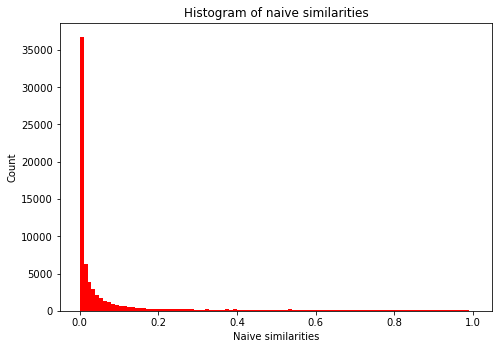

In [34]:
#Looking at similarities between the decoy spectra and target spectra


fig=plt.figure()
ax=fig.add_axes([0,0,1,1])

ax.hist(naive_similarities, bins=100, facecolor='red')

ax.set_xlabel("Naive similarities")
ax.set_ylabel("Count")
ax.set_title("Histogram of naive similarities")
plt.savefig("Histogram of naive similarities.jpg", bbox_inches='tight', dpi = 300)
plt.show()

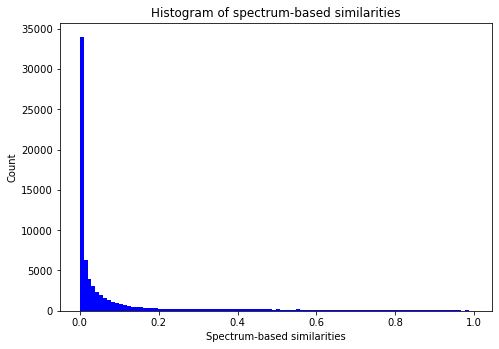

In [35]:
#Histogram of similarities between spectrum-based decoy spectra and corresponding target spectra

fig=plt.figure()
ax=fig.add_axes([0,0,1,1])

ax.hist(spectrum_based_similarities, bins=100, facecolor='blue')

ax.set_xlabel("Spectrum-based similarities")
ax.set_ylabel("Count")
ax.set_title("Histogram of spectrum-based similarities")
plt.savefig("Histogram of spectrum-based similarities.jpg", bbox_inches='tight', dpi = 300)
plt.show()

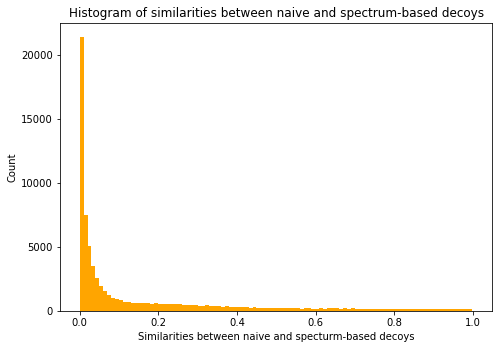

In [36]:
#Histogram of similarities between spectrum-based decoy spectra and naive_spectra

decoy_similarities = [cosine_greedy(spectrum_based_decoy_spectra[i], naive_decoy_spectra[i])[0] for i in range(len(target_spectra))]
decoy_similarities = np.array(decoy_similarities)


fig=plt.figure()
ax=fig.add_axes([0,0,1,1])

ax.hist(decoy_similarities, bins=100, facecolor='orange')

ax.set_xlabel("Similarities between naive and specturm-based decoys")
ax.set_ylabel("Count")
ax.set_title("Histogram of similarities between naive and spectrum-based decoys")
plt.savefig("Histogram of similarities between naive and spectrum-based decoys.jpg", bbox_inches='tight', dpi = 300)
plt.show()

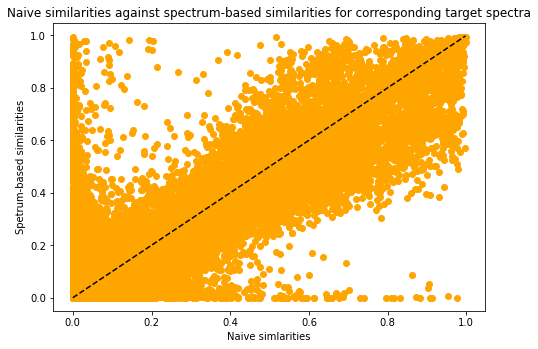

In [37]:
#Plot of naive similarities against spectrum-based similarities

order = np.argsort(naive_similarities)
naive_similarities = naive_similarities[order]
spectrum_based_similarities = spectrum_based_similarities[order]

xmax = np.max(naive_similarities)
ymax = np.max(spectrum_based_similarities)
ax_lim = xmax if xmax > ymax else ymax 

fig=plt.figure()
ax=fig.add_axes([0,0,1,1])

ax.scatter(naive_similarities, spectrum_based_similarities, color='orange')
ax.plot([0, ax_lim], [0,ax_lim], "r--", color = "black")

ax.set_xlabel("Naive simlarities")
ax.set_ylabel("Spetrum-based similarities")
ax.set_title("Naive similarities against spectrum-based similarities for corresponding target spectra")
plt.savefig("Naive similarities against spectrum-based similarities for corresponding target spectra.jpg", bbox_inches='tight', dpi = 300)
plt.show()

## Generating Spec2Vec Knockoffs

### Creating Spec2Vec Model

In [12]:
from spec2vec import SpectrumDocument

In [13]:
#Create target and query spectrum documents

documents_target = [SpectrumDocument(s, n_decimals=2) for s in target_spectra]
documents_query = [SpectrumDocument(s, n_decimals=2) for s in query_spectra]    
print(f"No. query documents, no. target documents: {len(documents_query), len(documents_target)}")

No. query documents, no. target documents: (1000, 72181)


In [39]:
#Creating model with 10 dimensions in the embedding space

from spec2vec.model_building import train_new_word2vec_model

path_models = os.path.join(ROOT, "Trained_Models")
model_file = os.path.join(path_models, "spec2vec_librarymatching_size_10.model")

iterations = [1, 3, 5, 10, 15, 20]

#Train model with size 10 and default parameters

model_s2v = train_new_word2vec_model(documents_target, iterations, model_file, size = 10)

The value of size is set from 300 (default) to 10
  Epoch 1 of 20.Change in loss after epoch 1: 5341984.0
Saving model with name: C:\Users\ashou\Downloads\FDR_Metabolomics\Trained_Models\librarymatching_size_10_iter_1.model
  Epoch 2 of 20.Change in loss after epoch 2: 4275092.0
  Epoch 3 of 20.Change in loss after epoch 3: 3849049.0
Saving model with name: C:\Users\ashou\Downloads\FDR_Metabolomics\Trained_Models\librarymatching_size_10_iter_3.model
  Epoch 4 of 20.Change in loss after epoch 4: 3822889.0
  Epoch 5 of 20.Change in loss after epoch 5: 3205800.0
Saving model with name: C:\Users\ashou\Downloads\FDR_Metabolomics\Trained_Models\librarymatching_size_10_iter_5.model
  Epoch 6 of 20.Change in loss after epoch 6: 3120934.0
  Epoch 7 of 20.Change in loss after epoch 7: 3207378.0
  Epoch 8 of 20.Change in loss after epoch 8: 3166542.0
  Epoch 9 of 20.Change in loss after epoch 9: 3207452.0
  Epoch 10 of 20.Change in loss after epoch 10: 1928220.0
Saving model with name: C:\Users\a

### Creating Knockoffs

In [15]:
import gensim
from sklearn.mixture import GaussianMixture as GMM
from spec2vec import calc_vector

In [16]:
#Load model

model_file = os.path.join(path_models, "spec2vec_librarymatching_size_10.model")
model_s2v = gensim.models.Word2Vec.load(model_file)

In [18]:
#Get spec2vec vectors for target and query spectra

target_vectors = [calc_vector(model_s2v, s, intensity_weighting_power=0.5, allowed_missing_percentage=15.0) for s in documents_target]
query_vectors = [calc_vector(model_s2v, s, intensity_weighting_power=0.5, allowed_missing_percentage=15.0) for s in documents_query]
target_vectors = np.array(target_vectors)
query_vectors = np.array(query_vectors)

Found 2 word(s) missing in the model. Weighted fraction not covered is 0.41%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.24%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 1.44%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 14.38%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.41%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.31%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.50%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 11.70%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.19%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 0.97%.


In [19]:
#Fitting Gaussian mixture model with 25 components, full covariance structure

no_comp = 25   #no components
gmm = GMM(n_components=no_comp, covariance_type="full")
model = gmm.fit(target_vectors)

In [28]:
#Generating knockoffs from GMM

from Create_Knockoffs import create_knockoffs

knockoffs = create_knockoffs(model, target_vectors)
print(f'No. knockoffs created: {len(knockoffs)}')

No. knockoffs created: 72181


### Looking at Similarities Between Target and Knockoff Spectra in the Embedding Space

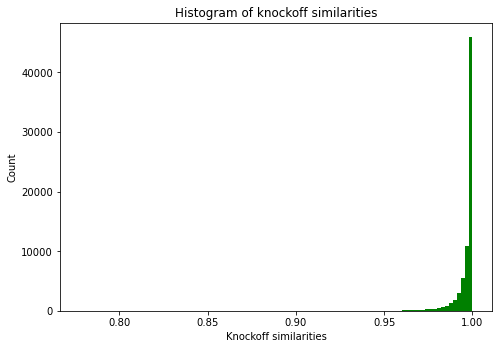

In [29]:
#Histogram of s2v_scores for knockoffs and their corresponding library embedding

#spec2vec score function can't be used directly here as our knockoffs are not spectrum documents
#Future changes may include storing the knockoffs as spectrum documents

import scipy 

def s2v_score(embedding_1, embedding_2):
    
    cdist = scipy.spatial.distance.cosine(embedding_1, embedding_2)
    return (1-cdist)


knockoff_similarities = [s2v_score(knockoffs[i], target_vectors[i]) for i in range(len(target_vectors))]
knockoff_similarities = np.array(knockoff_similarities)

#Plotting histogram

fig=plt.figure()
ax=fig.add_axes([0,0,1,1])

ax.hist(knockoff_similarities, bins=100, facecolor='green')

ax.set_xlabel("Knockoff similarities")
ax.set_ylabel("Count")
ax.set_title("Histogram of knockoff similarities")
plt.savefig("Histogram of knockoff similarities with 25 Gaussian components.jpg", bbox_inches='tight', dpi = 300)
plt.show()

## FDR Estimation

In [38]:
#Get merged hits for naive, and spectrum-based decoys, and knockoffs

from FDR_Estimation import get_hits_decoy
from FDR_Estimation import get_hits_knockoff

#Naive decoy hits

cosine_greedy = CosineGreedy(tolerance = 0.005)
naive_decoy_hits = get_hits_decoy(query_spectra, naive_decoy_spectra, cosine_greedy, type_hit = False)
target_hits = get_hits_decoy(query_spectra, target_spectra, cosine_greedy, type_hit = True)
naive_all_hits = pd.concat([naive_decoy_hits, target_hits], ignore_index = True)
naive_all_hits = naive_all_hits.sort_values(by = ["Cosine Score"], ascending= False)


#Spectrum-based decoy hits

spectrum_based_decoy_hits = get_hits_decoy(query_spectra, spectrum_based_decoy_spectra,  cosine_greedy, type_hit = False)
spectrum_based_all_hits = pd.concat([spectrum_based_decoy_hits, target_hits], ignore_index = True)
spectrum_based_all_hits = spectrum_based_all_hits.sort_values(by = ["Cosine Score"], ascending= False)

#Knockoff hits

knockoff_hits = get_hits_knockoff(query_vectors, documents_query, knockoffs, documents_target, s2v_score, type_hit = False)
target_hits = get_hits_knockoff(query_vectors, documents_query, target_vectors, documents_target, s2v_score, type_hit = True)
knockoff_all_hits = pd.concat([knockoff_hits, target_hits], ignore_index = True)
knockoff_all_hits = knockoff_all_hits.sort_values(by = ["Cosine Score"], ascending= False)

### Estimating Q-Values

In [40]:
#Getting the FDR for hits
#The FDRs are for hits are in order of sorted hits

from FDR_Estimation import estimate_FDR

estimated_FDRs_for_naive_hits = []
estimated_FDRs_for_spectrum_based_hits = []
estimated_FDRs_for_knockoff_hits = []
no_hits = len(knockoff_all_hits.index)
for i in range(1, no_hits + 1):
    
    hits_above_naive = naive_all_hits[0:i]
    hits_above_spectrum_based = spectrum_based_all_hits[0:i]
    hits_above_knockoff = knockoff_all_hits[0:i]    
    FDR_naive = estimate_FDR(hits_above_naive)
    FDR_spectrum_based = estimate_FDR(hits_above_spectrum_based)
    FDR_knockoff = estimate_FDR(hits_above_knockoff)
    estimated_FDRs_for_naive_hits.append(FDR_naive)
    estimated_FDRs_for_spectrum_based_hits.append(FDR_spectrum_based)
    estimated_FDRs_for_knockoff_hits.append(FDR_knockoff)


In [41]:
#Estimating q-values for target and decoy hits for query spectra 
#(Using both the naive and spectrum-based method of decoy generartion)

#For the naive method
#Going through each hit from all hits, and find their q-value:
#Go through all the possible score thresholds.
#Calculate their FDRs.
#The min. FDR at which this hit is in the output list is the q-value.

naive_estimated_q_values = []
spectrum_based_estimated_q_values = []
knockoff_estimated_q_values = []
for i in range(0, no_hits):
    
    naive_estimated_q_value = min(estimated_FDRs_for_naive_hits[i:no_hits])
    naive_estimated_q_values.append(naive_estimated_q_value)
    spectrum_based_estimated_q_value = min(estimated_FDRs_for_spectrum_based_hits[i:no_hits])
    spectrum_based_estimated_q_values.append(spectrum_based_estimated_q_value)
    knockoff_estimated_q_value = min(estimated_FDRs_for_knockoff_hits[i:no_hits])
    knockoff_estimated_q_values.append(knockoff_estimated_q_value)

### Calculating True Q-Values

In [42]:
#Getting the FDR for hits
#The FDRs are for hits a re in order of sorted hits

from FDR_Estimation import calculate_FDR

true_FDRs_for_naive_hits = []
true_FDRs_for_spectrum_based_hits = []
true_FDRs_for_knockoff_hits = []
for i in range(1, no_hits + 1):
    
    hits_above_naive = naive_all_hits[0:i]
    hits_above_spectrum_based = spectrum_based_all_hits[0:i]
    hits_above_knockoff = knockoff_all_hits[0:i]
    FDR_naive = calculate_FDR(hits_above_naive)
    FDR_spectrum_based = calculate_FDR(hits_above_spectrum_based)
    FDR_knockoff = calculate_FDR(hits_above_knockoff)
    true_FDRs_for_naive_hits.append(FDR_naive)
    true_FDRs_for_spectrum_based_hits.append(FDR_spectrum_based)
    true_FDRs_for_knockoff_hits.append(FDR_knockoff)


In [43]:
#Estimating q-values for target and decoy hits for query spectra 
#(Using both the naive and spectrum-based method of decoy generartion)

#For the naive method
#Going through each hit from all hits, and find their q-value:
#Go through all the possible score thresholds.
#Calculate their FDRs.
#The min. FDR at which this hit is in the output list is the q-value.

naive_true_q_values = []
spectrum_based_true_q_values = []
knockoff_true_q_values = []
for i in range(0, no_hits):
    
    naive_true_q_value = min(true_FDRs_for_naive_hits[i:no_hits])
    naive_true_q_values.append(naive_true_q_value)
    spectrum_based_true_q_value = min(true_FDRs_for_spectrum_based_hits[i:no_hits])
    spectrum_based_true_q_values.append(spectrum_based_true_q_value)
    knockoff_true_q_value = min(true_FDRs_for_knockoff_hits[i:no_hits])
    knockoff_true_q_values.append(knockoff_true_q_value)

### QQ-plots of True Q-Values vs. Estimated Q-Values

In [45]:
#Removing nans from q-values

#For naive method

naive_estimated_q_values = np.array(naive_estimated_q_values)
naive_true_q_values = np.array(naive_true_q_values)

naive_estimated_non_nans = np.where(~np.isnan(naive_estimated_q_values))[0]
naive_true_non_nans = np.where(~np.isnan(naive_true_q_values))[0]
naive_non_nans = np.intersect1d(naive_estimated_non_nans, naive_true_non_nans, assume_unique = True)
naive_estimated_q_values = naive_estimated_q_values[naive_non_nans]
naive_true_q_values = naive_true_q_values[naive_non_nans]

#For spectrum-based method

spectrum_based_estimated_q_values = np.array(spectrum_based_estimated_q_values)
spectrum_based_true_q_values = np.array(spectrum_based_true_q_values)

spectrum_based_estimated_non_nans = np.where(~np.isnan(spectrum_based_estimated_q_values))[0]
spectrum_based_true_non_nans = np.where(~np.isnan(spectrum_based_true_q_values))[0]
spectrum_based_non_nans = np.intersect1d(spectrum_based_estimated_non_nans, spectrum_based_true_non_nans, assume_unique = True)
spectrum_based_estimated_q_values = spectrum_based_estimated_q_values[spectrum_based_non_nans]
spectrum_based_true_q_values = spectrum_based_true_q_values[spectrum_based_non_nans]

#For knockoff method

knockoff_estimated_q_values = np.array(knockoff_estimated_q_values)
knockoff_true_q_values = np.array(knockoff_true_q_values)

knockoff_estimated_non_nans = np.where(~np.isnan(knockoff_estimated_q_values))[0]
knockoff_true_non_nans = np.where(~np.isnan(knockoff_true_q_values))[0]
knockoff_non_nans = np.intersect1d(knockoff_estimated_non_nans, knockoff_true_non_nans, assume_unique = True)
knockoff_estimated_q_values = knockoff_estimated_q_values[knockoff_non_nans]
knockoff_true_q_values = knockoff_true_q_values[knockoff_non_nans]

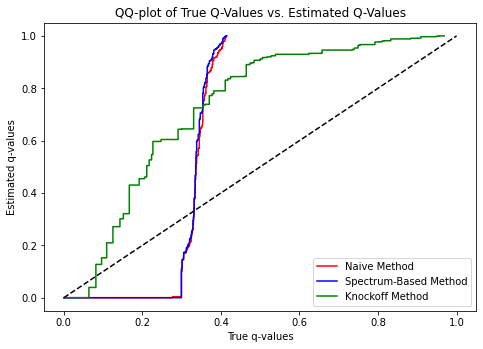

In [61]:
#QQ-plots of true qq-values against estimated q-values.
#For both the naive and spectrum-based methods of decoy generation

#Producing QQ-plot for the two decoy methods and knockoff method

xmax = np.max(np.concatenate((naive_estimated_q_values, spectrum_based_estimated_q_values, knockoff_estimated_q_values)))
ymax = np.max(np.concatenate((naive_true_q_values, spectrum_based_true_q_values, knockoff_true_q_values)))
ax_lim = xmax if xmax > ymax else ymax 

fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
#ax.scatter(naive_true_q_values, naive_estimated_q_values, color = "r", s=20)
#ax.scatter(spectrum_based_true_q_values, spectrum_based_estimated_q_values, color = "b", s=20)
#ax.scatter(knockoff_true_q_values, knockoff_estimated_q_values, color = "g", s=20)
ax.plot(naive_true_q_values, naive_estimated_q_values, color = "r", label = "Naive Method")
ax.plot(spectrum_based_true_q_values, spectrum_based_estimated_q_values, color = "b", label = "Spectrum-Based Method")
ax.plot(knockoff_true_q_values, knockoff_estimated_q_values, color = "green", label = "Knockoff Method")
ax.plot([0, ax_lim], [0,ax_lim], "r--", color = "black")

#ax.set_xlim(0, ax_lim)
#ax.set_ylim(0, ax_lim)
ax.set_ylabel('Estimated q-values')
ax.set_xlabel('True q-values')
ax.set_title('QQ-plot of True Q-Values vs. Estimated Q-Values')
ax.legend(loc="best")
plt.savefig("QQ-plot of True Q-Values vs. Estimated Q-Values.jpg", bbox_inches = "tight", dpi = 300)
plt.show()
